In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import corner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

2023-11-16 23:32:18.830927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 23:32:18.883757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 23:32:18.884712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 23:32:19.638415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('Alignment-1-Learning.csv')

In [3]:
data.head()

,mH1,mH2,mH3,mA1,mA2,mC1,mC2,TanBeta1,TanBeta2,TanAlpha4,TanGamma1,TanGamma2,TanAlpha1,TanAlpha2,Output
0,125.0,389.681890,266.205554,357.716926,216.548541,437.974724,291.549211,1.825617,0.708838,5.560399,21.627008,24.836633,1.825617,0.708838,1
1,125.0,466.478864,389.569317,402.965051,380.172764,364.184617,381.934382,1.054113,0.609084,10.036226,20.546985,15.891286,1.054113,0.609084,1
2,125.0,220.948750,486.689377,537.099375,320.173513,243.467599,406.498383,1.303290,0.919230,13.261847,23.903331,21.670848,1.303290,0.919230,1
3,125.0,328.343580,323.472676,221.752325,348.389320,487.707855,305.971767,0.793804,0.669176,11.678012,12.508026,14.745824,0.793804,0.669176,1
4,125.0,335.247929,211.280269,206.867278,340.005918,207.546645,227.085078,2.043520,1.108583,16.270581,13.387200,20.521982,2.043520,1.108583,1


In [4]:
#check for any empty cell in the database
data.isna().sum()

mH1          0
mH2          0
mH3          0
mA1          0
mA2          0
mC1          0
mC2          0
TanBeta1     0
TanBeta2     0
TanAlpha4    0
TanGamma1    0
TanGamma2    0
TanAlpha1    0
TanAlpha2    0
Output       0
dtype: int64

In [5]:
#shuffle the dataframe

data_sh = data.sample(frac = 1.0, random_state = 52)

#reset the index

data_sh = data_sh.reset_index(drop=True)

In [6]:
#put feature variable to X and target variable to Y

X = data_sh.drop('Output', axis = 1)
Y = data_sh['Output']

In [7]:
# data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

column_names = ['mH1','mH2','mH3','mA1','mA2','mC1','mC2','TanBeta1','TanBeta2','TanAlpha4','TanGamma1','TanGamma2','TanAlpha1','TanAlpha2']

X = pd.DataFrame(X_scaled, columns=column_names)

In [8]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.94, random_state = 52)

#Split the training data further into labeled and unlabeled dataset

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size = 0.9995, random_state = 52)

In [9]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of labeled datapoints: {len(X_labeled)}")
print(f"Number of unlabeled datapoints: {len(X_unlabeled)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 81736
Number of labeled datapoints: 2
Number of unlabeled datapoints: 4902
Number of test datapoints: 76832


In [10]:
frac_unlabeled = Y_unlabeled.sum()/len(Y_unlabeled)
frac_labeled = Y_labeled.sum()/len(Y_labeled)
frac_test = Y_test.sum()/len(Y_test)

In [11]:
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")
print(f"Fraction of allowed points in unlabeled dataset: {frac_unlabeled}")
print(f"Fraction of allowed points in test dataset: {frac_test}")

Fraction of allowed points in labeled dataset: 0.5
Fraction of allowed points in unlabeled dataset: 0.4934720522235822
Fraction of allowed points in test dataset: 0.4986984589754269


In [12]:
# Set random seeds for reproducibility
seed_value = 52
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [13]:
#define your model
model1 = keras.Sequential()

# Add input layer with 14 input parameters
model1.add(layers.Input(shape=(X.shape[1],)))

model1.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.6))

model1.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.6))

model1.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.6))

model1.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  # You can adjust this value as needed

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model1.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [14]:
#define your model
model2 = keras.Sequential()

# Add input layer with 14 input parameters
model2.add(layers.Input(shape=(X.shape[1],)))

model2.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.6))

model2.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.6))

model2.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.6))

model2.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.6))

model2.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  # You can adjust this value as needed

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model2.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1920      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                     

In [15]:
#define your model
model3 = keras.Sequential()

# Add input layer with 14 input parameters
model3.add(layers.Input(shape=(X.shape[1],)))

model3.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.6))

model3.add(layers.Dense(128, kernel_regularizer=l2(0.001)))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.6))

model3.add(layers.Dense(64, kernel_regularizer=l2(0.001)))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.6))

model3.add(layers.Dense(32, kernel_regularizer=l2(0.001)))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Dropout(0.6))

model3.add(layers.Dense(1, activation = 'sigmoid'))

custom_learning_rate = 0.001  # You can adjust this value as needed

# Compile the model with a custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
model3.compile(loss='binary_crossentropy', optimizer=custom_optimizer)

# Display the model summary to see the architecture
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                480       
                                                                 
 batch_normalization_7 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               4224      
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                     

In [16]:
#active learning loop
num_iterations = 40

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)
precision_array = np.zeros(num_iterations+1)
recall_array = np.zeros(num_iterations+1)
f1_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    model1.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    model2.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    model3.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
    
    #Get model predictions on the test data
    Y_pred_test1 = model1.predict(X_test, verbose=0).ravel()
    Y_pred_test2 = model2.predict(X_test, verbose=0).ravel()
    Y_pred_test3 = model3.predict(X_test, verbose=0).ravel()
    
    #combined predictions
    Y_pred_test = (Y_pred_test1 + Y_pred_test2 + Y_pred_test3)/3
    
    #Convert the predictions into binary
    Y_pred_binary = (Y_pred_test > 0.5).astype(int)
    
    #Calculate accuracy,precision,recall and F1 Score on the test set
    accuracy = accuracy_score(Y_test, Y_pred_binary)
    accuracy_array[iteration] = accuracy
    precision = precision_score(Y_test, Y_pred_binary)
    precision_array[iteration] = precision
    recall = recall_score(Y_test, Y_pred_binary)
    recall_array[iteration] = recall
    f1 = f1_score(Y_test, Y_pred_binary)
    f1_array[iteration] = f1
    frac_labeled = Y_labeled.sum()/len(Y_labeled)
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    print(f"Iteration : {iteration + 1}: Test Precision = {precision:.6f}")
    print(f"Iteration : {iteration + 1}: Test Recall = {recall:.6f}")
    print(f"Iteration : {iteration + 1}: Test F1 = {f1:.6f}")
    print(f"Iteration : {iteration + 1}: Fraction of allowed points in labeled dataset = {frac_labeled}")
    print(" ") #Print a blank line
    
    #Get model predictions on the unlabeled data
    Y_pred_unlabel1 = model1.predict(X_unlabeled, verbose=0).ravel()
    Y_pred_unlabel2 = model2.predict(X_unlabeled, verbose=0).ravel()
    Y_pred_unlabel3 = model3.predict(X_unlabeled, verbose=0).ravel()
    
    #Calculate entropy
    entropy1 = -Y_pred_unlabel1*np.log2(Y_pred_unlabel1+1e-30) - (1-Y_pred_unlabel1)*np.log2(1-Y_pred_unlabel1+1e-30)
    entropy2 = -Y_pred_unlabel2*np.log2(Y_pred_unlabel2+1e-30) - (1-Y_pred_unlabel2)*np.log2(1-Y_pred_unlabel2+1e-30)
    entropy3 = -Y_pred_unlabel3*np.log2(Y_pred_unlabel3+1e-30) - (1-Y_pred_unlabel3)*np.log2(1-Y_pred_unlabel3+1e-30)
    
    entropy = (entropy1 + entropy2 + entropy3)/3
    
    #Select the most uncertain samples
    num_samples_to_label = 2
    selected_indices = np.argsort(entropy)[-num_samples_to_label:]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
#Train the final model on all labeled data 
model1.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
model2.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)
model3.fit(X_labeled,Y_labeled, epochs=150, batch_size=32, verbose=0)

#Evaluate the final model on the test data
Y_pred_test1 = model1.predict(X_test, verbose=0).ravel()
Y_pred_test2 = model2.predict(X_test, verbose=0).ravel()   
Y_pred_test3 = model3.predict(X_test, verbose=0).ravel()  

#combined predictions
Y_pred_test = (Y_pred_test1 + Y_pred_test2 + Y_pred_test3)/3
    
#Convert the predictions into binary
Y_pred_binary = (Y_pred_test > 0.5).astype(int)

#Calculate various metric scores
final_accuracy = accuracy_score(Y_test, Y_pred_binary)
accuracy_array[-1] = final_accuracy
final_precision = precision_score(Y_test, Y_pred_binary)
precision_array[-1] = final_precision
final_recall = recall_score(Y_test, Y_pred_binary)
recall_array[-1] = final_recall
final_f1 = f1_score(Y_test, Y_pred_binary)
f1_array[-1] = final_f1
frac_labeled = Y_labeled.sum()/len(Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")
print(f"Final Model Test Precision: {final_precision:.6f}")
print(f"Final Model Test Recall: {final_recall:.6f}")
print(f"Final Model Test F1: {final_f1:.6f}")
print(f"Fraction of allowed points in labeled dataset: {frac_labeled}")

Iteration : 1: Test Accuracy = 0.900484
Iteration : 1: Test Precision = 0.874298
Iteration : 1: Test Recall = 0.934858
Iteration : 1: Test F1 = 0.903564
Iteration : 1: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 2: Test Accuracy = 0.922741
Iteration : 2: Test Precision = 0.872526
Iteration : 2: Test Recall = 0.989665
Iteration : 2: Test F1 = 0.927411
Iteration : 2: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 3: Test Accuracy = 0.965730
Iteration : 3: Test Precision = 0.935701
Iteration : 3: Test Recall = 1.000000
Iteration : 3: Test F1 = 0.966782
Iteration : 3: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 4: Test Accuracy = 0.967618
Iteration : 4: Test Precision = 0.939047
Iteration : 4: Test Recall = 0.999974
Iteration : 4: Test F1 = 0.968553
Iteration : 4: Fraction of allowed points in labeled dataset = 0.375
 
Iteration : 5: Test Accuracy = 0.990186
Iteration : 5: Test Precision = 0.980824
Iteration : 5: Test Recall = 

Iteration : 36: Test Accuracy = 0.999479
Iteration : 36: Test Precision = 0.998957
Iteration : 36: Test Recall = 1.000000
Iteration : 36: Test F1 = 0.999478
Iteration : 36: Fraction of allowed points in labeled dataset = 0.4583333333333333
 
Iteration : 37: Test Accuracy = 0.999453
Iteration : 37: Test Precision = 0.998905
Iteration : 37: Test Recall = 1.000000
Iteration : 37: Test F1 = 0.999452
Iteration : 37: Fraction of allowed points in labeled dataset = 0.47297297297297297
 
Iteration : 38: Test Accuracy = 0.999531
Iteration : 38: Test Precision = 0.999061
Iteration : 38: Test Recall = 1.000000
Iteration : 38: Test F1 = 0.999530
Iteration : 38: Fraction of allowed points in labeled dataset = 0.4868421052631579
 
Iteration : 39: Test Accuracy = 0.999557
Iteration : 39: Test Precision = 0.999113
Iteration : 39: Test Recall = 1.000000
Iteration : 39: Test F1 = 0.999557
Iteration : 39: Fraction of allowed points in labeled dataset = 0.5
 
Iteration : 40: Test Accuracy = 0.999531
Itera

Text(0, 0.5, 'F1-score')

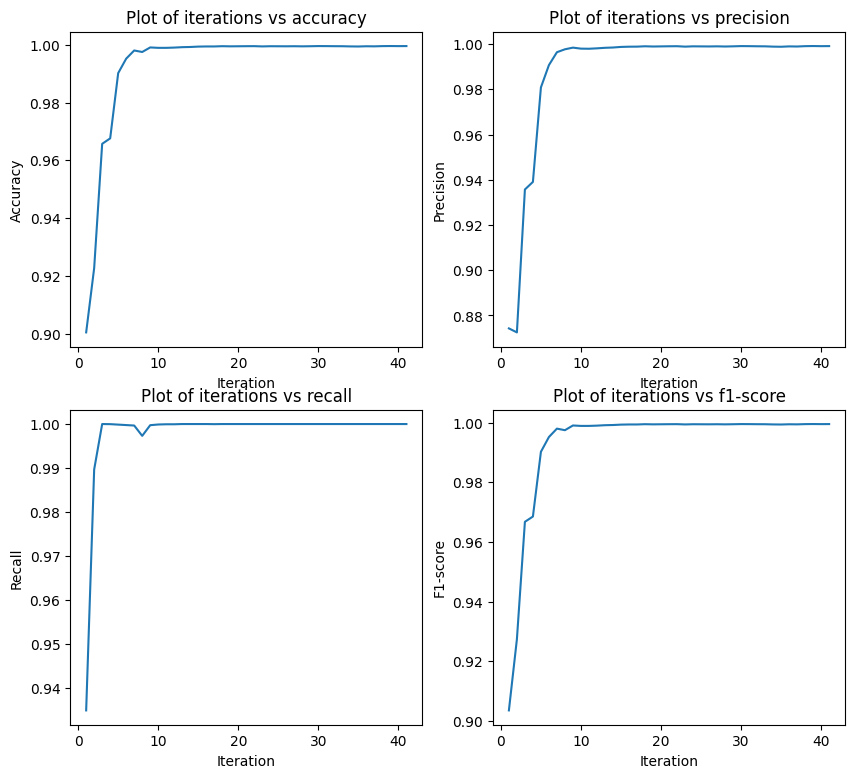

In [17]:
# Plot iteration vs accuracy

plt.figure(figsize=(10, 9))

plt.subplot(2,2,1)
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

# Plot iteration vs precision

plt.subplot(2,2,2)
plt.plot(num_it_array, precision_array)
plt.title("Plot of iterations vs precision")
plt.xlabel("Iteration")
plt.ylabel("Precision")

# Plot iteration vs recall

plt.subplot(2,2,3)
plt.plot(num_it_array, recall_array)
plt.title("Plot of iterations vs recall")
plt.xlabel("Iteration")
plt.ylabel("Recall")

# Plot iteration vs f1-score

plt.subplot(2,2,4)
plt.plot(num_it_array, f1_array)
plt.title("Plot of iterations vs f1-score")
plt.xlabel("Iteration")
plt.ylabel("F1-score")